## 0. Imporing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from keras.preprocessing.text import text_to_word_sequence
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Prepare data

In [4]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/ML/preprocessing')
import Preprocessor

### 1.1. Load data

In [5]:
import tensorflow_datasets as tfds
dataset = tfds.load('imdb_reviews', as_supervised=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEWWKWZ/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEWWKWZ/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEWWKWZ/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [6]:
X_train, y_train, X_test, y_test = Preprocessor.load_prep(dataset)  

### 1.2. TF-IDF Vectorisation

In [7]:
def func(doc):  # n_jobs in GridSearch does not support lambda function
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 3),  # ngram_range is tuned for SVM
    tokenizer=func,
    preprocessor=func) 

tfidf.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


TfidfVectorizer(ngram_range=(1, 3),
                preprocessor=<function func at 0x7f010e4fd830>,
                tokenizer=<function func at 0x7f010e4fd830>)

In [8]:
tfidf.vocabulary_

{'bthis': 595693,
 'absolutely': 19413,
 'terrible': 4217087,
 'movie': 2786750,
 'dont': 1179277,
 'lured': 2551897,
 'christopher': 770395,
 'walken': 4570086,
 'michael': 2705582,
 'ironside': 2199716,
 'great': 1869786,
 'actors': 55911,
 'must': 2872243,
 'simply': 3864350,
 'worst': 4752232,
 'role': 3575903,
 'history': 2011391,
 'even': 1359132,
 'acting': 39261,
 'could': 923909,
 'redeem': 3472574,
 'movies': 2829724,
 'ridiculous': 3551474,
 'storyline': 4066059,
 'early': 1236389,
 'nineties': 2944747,
 'us': 4489493,
 'propaganda': 3349062,
 'piece': 3198670,
 'pathetic': 3131586,
 'scenes': 3663431,
 'columbian': 825440,
 'rebels': 3460851,
 'making': 2596404,
 'cases': 676874,
 'revolutions': 3543750,
 'maria': 2629169,
 'conchita': 874571,
 'alonso': 131976,
 'appeared': 219849,
 'phony': 3188731,
 'pseudo': 3359643,
 'love': 2529258,
 'affair': 90024,
 'nothing': 2961165,
 'emotional': 1282910,
 'plug': 3248061,
 'devoid': 1096249,
 'real': 3430181,
 'meaning': 2669736

In [9]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

## 2. Model training

### 2.1. Default hyperparameter values

In [ ]:
classifier_def  = LinearSVC()  # default C=1.0
classifier_def.fit(X_train_tf, y_train)

y_pred_train_def = classifier_def.predict(X_train_tf)
y_pred_test_def = classifier_def.predict(X_test_tf)

print("Train: ", accuracy_score(y_train, y_pred_train_def))
print("Test: ", accuracy_score(y_test, y_pred_test_def))

Train:  0.99996
Test:  0.8898


### 2.2. Hyperparameter tuning

SVM has one hyperparameter that we need to tune: C i.e. the penalty term. We will choose this hyperparameter based on the Grid Search with Cross-validation schema.

In [ ]:
from sklearn.model_selection import validation_curve

indices = np.arange(y_train.shape[0])
param_range=[0.1, .5, 1, 2]

train_scores, test_scores = validation_curve(LinearSVC(random_state=0), X_train_tf, y_train,
                                            param_name='C', param_range=param_range, cv=10, scoring='accuracy', n_jobs=-1)


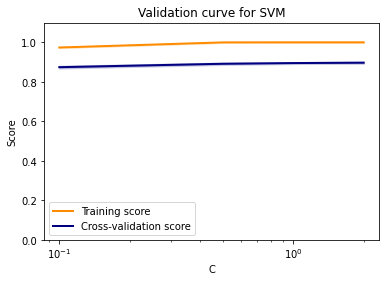

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation curve for SVM')
plt.xlabel('C')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw=2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

The model seems to start overfit since `C=0.8`.

In [ ]:
indices = np.arange(y_train.shape[0])
param_range=[0.4, .5, .6, .65, .7, .8]

train_scores, test_scores = validation_curve(LinearSVC(random_state=0), X_train_tf, y_train,
                                            param_name='C', param_range=param_range, cv=10, scoring='accuracy', n_jobs=-1)


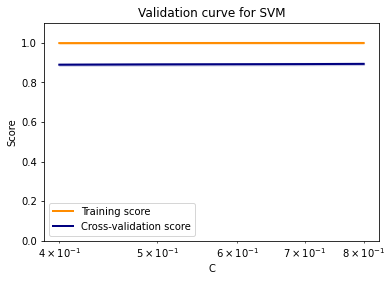

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation curve for SVM')
plt.xlabel('C')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw=2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

Comment: changing the value of `C` seems to make little difference, C=.5 should suffice, balancing the running time and slightly reduce overfitting. 

In [10]:
clf = LinearSVC(C=.5, random_state=0)
clf.fit(X_train_tf, y_train)

y_pred_train = clf.predict(X_train_tf)
y_pred_test = clf.predict(X_test_tf)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print("Train: ", train_acc)
print("Test: ", test_acc)

Train:  0.99964
Test:  0.8878


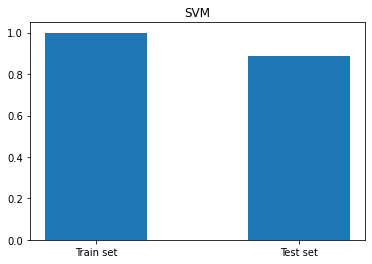

In [ ]:
plt.bar(["Train set", "Test set"], [train_acc, test_acc], width=.5)
plt.title("SVM")

plt.show()

### 2.3. Model evaluation

We can plot the following Confusion Matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


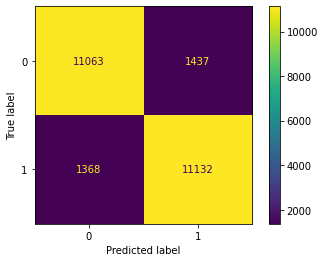

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test_tf, y_test)  
plt.show()

## 3. Predicting new instances

In [11]:
# positive review
sentence = "Was foolishly overthought about watching it at cinemas, due to criticism, but the movie was actually a welcomed change to the previous marvel phase setup, it was not boring at any point for the duration of the movie and it was interesting to see how easily things can go really bad that even Thanos Crusade that was the big deal can seem so simple and trivial.Some comments that i noticed complained about 'not enough multiverse etc etc' the movie was not called Doctor Strange visits any other universe :) the movie played with multiverse and showed some different ways that interacting with one another can have a number of unpredictable results .If someone wants a more deep dive into the theme i suggest to watch Loki series, there its explained and shown in a slower pace with more detailOverall a Solid entry for the Genre, and honestly most of the negative comments and chatter can be applied for the most marvel movies out there if taken serious!"

In [12]:
review = pd.Series(sentence)
stop_words = set(stopwords.words("english"))
review_clean = review.map(lambda x: Preprocessor.clean_text(x, word_tokenize, stop_words))

In [13]:
review_tf = tfidf.transform(review_clean)

In [14]:
print(review_clean)

0    [foolishly, overthought, watching, cinemas, du...
dtype: object


In [15]:
clf.predict(review_tf)

array([1])

In [16]:
# negative review
sentence2 = "After months of hype, we are left with a mess of a story that is mostly just CGI blobs, some light shows and some boring dialogue. I loved the first Strange movie, its my second favorite after Captain America Winter Soldier. So this was extra disappointing.Firstly, youre not going to have any idea whats going on with the main antagonist unless you watched the Disney+ show Wandavision. Even though I did watch it, it had been months, and I didnt remember all the details, so her whole backstory fell flat. This movie was less about Strange and more about her.Theres also a subplot involving Stranges old flame, but since we only saw them as exes in the previous film, it Didnt really feel that impactful.Theres also an obligatory teen sidekick, which I guess is now standard in the Phase IV fully Disneyized MCU. She might have been interesting, but shes just there as a macguffiin and has no real personality.Theres also random cameos from other Marvel properties, Im beginning to see these bits of crossover fan service are the sole purpose of having a multiverse.Seriously, I dont know why I keep giving my money to this franchise. Black Widow, Eternals, Shang Chi and now Dr Strange 2, have all been dull, uninspired CGI crap fests, that rely entirely on cameos and fan service to keep people coming back. Lets just face it, Hollywood milked all they could from Marvel. Its time to give the franchise ( and maybe all superhero movies)a good 10-15 year rest and reboot it after audiences grow nostalgic."
review_clean2 = pd.Series(sentence2).map(lambda x: Preprocessor.clean_text(x, word_tokenize, stop_words))

In [17]:
clf.predict(tfidf.transform(review_clean2))

array([0])